<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/experiments/Small_Molecular_Graph_Generation_for_Drug_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Small Molecular Graph Generation for Drug Discovery**

## **Important Libraries**

In [ ]:
!pip install -q --no-cache-dir lightning rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 193.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 177.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 126.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 254.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 124.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 150.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 193.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 148.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 136.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 187.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import torch.autograd as autograd
from torch.autograd import Variable

import pickle
import gzip

from rdkit import DataStructs
from rdkit.Chem import QED
from rdkit.Chem import Crippen
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import math
import pandas as pd


%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
RDLogger.DisableLog("rdApp.*")

## **Dataset**

### **Download**

In [ ]:
!wget --no-verbose "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
!wget --no-verbose "https://github.com/gablg1/ORGAN/raw/master/organ/NP_score.pkl.gz"
!wget --no-verbose "https://github.com/gablg1/ORGAN/raw/master/organ/SA_score.pkl.gz"
df = pd.read_csv("/content/qm9.csv")
SMILES = df['smiles'].to_numpy().tolist()
print(SMILES)
df.head()

### **Utils**

In [ ]:
NUM_ATOMS = 9  # Maximum number of atoms
ATOM_DIM = 4 + 1  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
ATOM_MAPPING = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}
BOND_MAPPING = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}
EVAL_SAMPLE = 6561
LATENT_DIM = 169

In [ ]:
def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = ATOM_MAPPING[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = BOND_MAPPING[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(adjacency, features):

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(ATOM_MAPPING[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = BOND_MAPPING[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

In [ ]:
class QM9Dataset(data.Dataset):
    def __init__(self, split=None):
        super().__init__()
        assert (
            split is not None
        ), "Dataset split must be: train, val, test, and inference"

        self._split = split
        self._adj_dataset = list()
        self._feat_dataset = list()

        if self._split == "train":
            smiles = SMILES.copy()
            random.shuffle(smiles)
            for sm in smiles[::1]:
                adj, feat = smiles_to_graph(sm)
                self._adj_dataset.append(adj)
                self._feat_dataset.append(feat)

    def __len__(self):
        if self._split == "train":
            return len(self._adj_dataset)
        elif self._split in ["val", "test"]:
            return EVAL_SAMPLE
        else:
            return 1

    def __getitem__(self, idx):
        if self._split == "train":
            adj = torch.from_numpy(np.array(self._adj_dataset[idx]).astype("float32"))
            feat = torch.from_numpy(np.array(self._feat_dataset[idx]).astype("float32"))

            return adj, feat
        else:
            z = torch.Tensor(np.random.normal(0, 1, (LATENT_DIM)))
            return z

In [ ]:
TrainDataset = QM9Dataset(split="train")
ValDataset = QM9Dataset(split="val")
TestDataset = QM9Dataset(split="test")

## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.losses = []

    def update(self, val):
        self.losses.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.losses[np.maximum(len(self.losses)-self.num, 0):]
            )
        )
        return out

In [ ]:
NP_model = pickle.load(gzip.open("/content/NP_score.pkl.gz"))
SA_model = {
    i[j]: float(i[0])
    for i in pickle.load(gzip.open("/content/SA_score.pkl.gz"))
    for j in range(1, len(i))
}


class MolecularMetrics(object):
    @staticmethod
    def _avoid_sanitization_error(op):
        try:
            return op()
        except ValueError:
            return None

    @staticmethod
    def remap(x, x_min, x_max):
        return (x - x_min) / (x_max - x_min)

    @staticmethod
    def valid_lambda(x):
        return x is not None and Chem.MolToSmiles(x) != ""

    @staticmethod
    def valid_lambda_special(x):
        s = Chem.MolToSmiles(x) if x is not None else ""
        return x is not None and "*" not in s and "." not in s and s != ""

    @staticmethod
    def valid_scores(mols):
        return np.array(
            list(map(MolecularMetrics.valid_lambda_special, mols)), dtype=np.float32
        )

    @staticmethod
    def valid_filter(mols):
        return list(filter(MolecularMetrics.valid_lambda, mols))

    @staticmethod
    def valid_total_score(mols):
        return np.array(
            list(map(MolecularMetrics.valid_lambda, mols)), dtype=np.float32
        ).mean()

    @staticmethod
    def novel_scores(mols):
        return np.array(
            list(
                map(
                    lambda x: MolecularMetrics.valid_lambda(x)
                    and Chem.MolToSmiles(x) not in SMILES,
                    mols,
                )
            )
        )

    @staticmethod
    def novel_filter(mols):
        return list(
            filter(
                lambda x: MolecularMetrics.valid_lambda(x)
                and Chem.MolToSmiles(x) not in SMILES,
                mols,
            )
        )

    @staticmethod
    def novel_total_score(mols):
        return MolecularMetrics.novel_scores(
            MolecularMetrics.valid_filter(mols)
        ).mean()

    @staticmethod
    def unique_scores(mols):
        smiles = list(
            map(
                lambda x: Chem.MolToSmiles(x)
                if MolecularMetrics.valid_lambda(x)
                else "",
                mols,
            )
        )
        return np.clip(
            0.75
            + np.array(
                list(map(lambda x: 1 / smiles.count(x) if x != "" else 0, smiles)),
                dtype=np.float32,
            ),
            0,
            1,
        )

    @staticmethod
    def unique_total_score(mols):
        v = MolecularMetrics.valid_filter(mols)
        s = set(map(lambda x: Chem.MolToSmiles(x), v))
        return 0 if len(v) == 0 else len(s) / len(v)

    @staticmethod
    def natural_product_scores(mols, norm=False):
        # calculating the score
        scores = [
            sum(
                NP_model.get(bit, 0)
                for bit in Chem.rdMolDescriptors.GetMorganFingerprint(
                    mol, 2
                ).GetNonzeroElements()
            )
            / float(max(mol.GetNumAtoms(), 1))
            if mol is not None
            else None
            for mol in mols
        ]

        # preventing score explosion for exotic molecules
        scores = list(
            map(
                lambda score: score
                if score is None
                else (
                    4 + math.log10(score - 4 + 1)
                    if score > 4
                    else (-4 - math.log10(-4 - score + 1) if score < -4 else score)
                ),
                scores,
            )
        )

        scores = np.array(list(map(lambda x: -4 if x is None else x, scores)))
        scores = (
            np.clip(MolecularMetrics.remap(scores, -3, 1), 0.0, 1.0) if norm else scores
        )

        return scores

    @staticmethod
    def quantitative_estimation_druglikeness_scores(mols, norm=False):
        return np.array(
            list(
                map(
                    lambda x: 0 if x is None else x,
                    [
                        MolecularMetrics._avoid_sanitization_error(lambda: QED.qed(mol))
                        if mol is not None
                        else None
                        for mol in mols
                    ],
                )
            )
        )

    @staticmethod
    def water_octanol_partition_coefficient_scores(mols, norm=False):
        scores = [
            MolecularMetrics._avoid_sanitization_error(lambda: Crippen.MolLogP(mol))
            if mol is not None
            else None
            for mol in mols
        ]
        scores = np.array(list(map(lambda x: -3 if x is None else x, scores)))
        scores = (
            np.clip(
                MolecularMetrics.remap(scores, -2.12178879609, 6.0429063424), 0.0, 1.0
            )
            if norm
            else scores
        )

        return scores

    @staticmethod
    def _compute_SAS(mol):
        fp = Chem.rdMolDescriptors.GetMorganFingerprint(mol, 2)
        fps = fp.GetNonzeroElements()
        score1 = 0.0
        nf = 0
        # for bitId, v in fps.items():
        for bitId, v in fps.items():
            nf += v
            sfp = bitId
            score1 += SA_model.get(sfp, -4) * v
        try:
            score1 /= nf
        except:
            score1 = 0.0

        # features score
        nAtoms = mol.GetNumAtoms()
        nChiralCenters = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        ri = mol.GetRingInfo()
        nSpiro = Chem.rdMolDescriptors.CalcNumSpiroAtoms(mol)
        nBridgeheads = Chem.rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
        nMacrocycles = 0
        for x in ri.AtomRings():
            if len(x) > 8:
                nMacrocycles += 1

        sizePenalty = nAtoms**1.005 - nAtoms
        stereoPenalty = math.log10(nChiralCenters + 1)
        spiroPenalty = math.log10(nSpiro + 1)
        bridgePenalty = math.log10(nBridgeheads + 1)
        macrocyclePenalty = 0.0

        # ---------------------------------------
        # This differs from the paper, which defines:
        #  macrocyclePenalty = math.log10(nMacrocycles+1)
        # This form generates better results when 2 or more macrocycles are present
        if nMacrocycles > 0:
            macrocyclePenalty = math.log10(2)

        score2 = (
            0.0
            - sizePenalty
            - stereoPenalty
            - spiroPenalty
            - bridgePenalty
            - macrocyclePenalty
        )

        # correction for the fingerprint density
        # not in the original publication, added in version 1.1
        # to make highly symmetrical molecules easier to synthetise
        score3 = 0.0
        if nAtoms > len(fps):
            score3 = math.log(float(nAtoms) / len(fps)) * 0.5

        sascore = score1 + score2 + score3

        # need to transform "raw" value into scale between 1 and 10
        min = -4.0
        max = 2.5
        sascore = 11.0 - (sascore - min + 1) / (max - min) * 9.0
        # smooth the 10-end
        if sascore > 8.0:
            sascore = 8.0 + math.log(sascore + 1.0 - 9.0)
        if sascore > 10.0:
            sascore = 10.0
        elif sascore < 1.0:
            sascore = 1.0

        return sascore

    @staticmethod
    def synthetic_accessibility_score_scores(mols, norm=False):
        scores = [
            MolecularMetrics._compute_SAS(mol) if mol is not None else None
            for mol in mols
        ]
        scores = np.array(list(map(lambda x: 10 if x is None else x, scores)))
        scores = (
            np.clip(MolecularMetrics.remap(scores, 5, 1.5), 0.0, 1.0)
            if norm
            else scores
        )

        return scores

    @staticmethod
    def diversity_scores(mols):
        rand_smiles = np.random.choice(SMILES, 100)
        fps = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sml), 4, nBits=2048) for sml in rand_smiles]

        scores = np.array(
            list(map(lambda x: MolecularMetrics.__compute_diversity(x, fps) if x is not None else 0, mols)))
        scores = np.clip(MolecularMetrics.remap(scores, 0.9, 0.945), 0.0, 1.0)

        return scores

    @staticmethod
    def __compute_diversity(mol, fps):
        ref_fps = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
        dist = DataStructs.BulkTanimotoSimilarity(ref_fps, fps, returnDistance=True)
        score = np.mean(dist)
        return score

    @staticmethod
    def drugcandidate_scores(mols):
        scores = (
            MolecularMetrics.constant_bump(
                MolecularMetrics.water_octanol_partition_coefficient_scores(
                    mols, norm=True
                ),
                0.210,
                0.945,
            )
            + MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
            + MolecularMetrics.novel_scores(mols)
            + (1 - MolecularMetrics.novel_scores(mols)) * 0.3
        ) / 4

        return scores

    @staticmethod
    def constant_bump(x, x_low, x_high, decay=0.025):
        return np.select(
            condlist=[x <= x_low, x >= x_high],
            choicelist=[
                np.exp(-((x - x_low) ** 2) / decay),
                np.exp(-((x - x_high) ** 2) / decay),
            ],
            default=np.ones_like(x),
        )

### **GAN**

In [ ]:
class GraphGenerator(nn.Module):
    def __init__(self, latent_dim, bond_dim, num_atoms, atom_dim):
        super().__init__()

        self.z_proj = nn.Sequential(
            nn.Linear(latent_dim, 196),
            nn.Tanh(),
            nn.Linear(196, 289),
            nn.Tanh(),
            nn.Linear(289, 576),
            nn.Tanh(),
            nn.Linear(576, 1024),
            nn.Tanh(),
        )

        self.adj_proj = nn.Sequential(
            nn.Linear(1024, int(bond_dim * num_atoms * num_atoms)),
        )

        self.feat_proj = nn.Sequential(
            nn.Linear(1024, int(num_atoms * atom_dim)),
        )

        self.bond_dim = bond_dim
        self.num_atoms = num_atoms
        self.atom_dim = atom_dim

    def forward(self, z):
        batch_size = z.size()[0]

        z = self.z_proj(z)

        adj = self.adj_proj(z).view(
            batch_size, self.bond_dim, self.num_atoms, self.num_atoms
        )
        # Symmetrify tensors in the last two dimensions
        adj = (adj + adj.permute(0, 1, 3, 2)) / 2.
        adj = adj.softmax(axis=1)

        feat = self.feat_proj(z).view(
            batch_size, self.num_atoms, self.atom_dim
        )
        feat = feat.softmax(axis=2)

        return adj, feat

In [ ]:
class RelationalGraphConvLayer(nn.Module):
    def __init__(self, bond_dim, atom_dim, latent_dim, bias=True):
        super().__init__()

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        kernel_data = torch.rand(
            1, bond_dim, atom_dim, latent_dim
        ).to(device)
        self.kernel = nn.Parameter(data=kernel_data, requires_grad=True)
        self.is_bias = bias
        if self.is_bias:
            bias_data = torch.rand(
                1, bond_dim, 1, latent_dim
            ).to(device)
            self.bias = nn.Parameter(data=bias_data, requires_grad=True)

    def forward(self, adj, feat):
        feat = torch.matmul(adj, feat[:, None, :, :])
        feat = torch.matmul(feat, self.kernel)
        if self.is_bias:
            feat = feat + self.bias
        feat = feat.mean(dim=1)
        return adj, F.relu(feat)

In [ ]:
class GraphDiscriminator(nn.Module):
    def __init__(self, latent_dim, bond_dim, atom_dim):
        super().__init__()

        self.gnn0 = RelationalGraphConvLayer(bond_dim, atom_dim, 64)
        self.gnn1 = RelationalGraphConvLayer(bond_dim, 64, 144)
        self.gnn2 = RelationalGraphConvLayer(bond_dim, 144, 256)
        self.gnn3 = RelationalGraphConvLayer(bond_dim, 256, 529)

        self.mlp = nn.Sequential(
            nn.Linear(529, 225),
            nn.ReLU(True),
            nn.Linear(225, 1),
        )

        self.layer_norm = nn.LayerNorm(529)

    def forward(self, adj, feat):
        adj, feat = self.gnn0(adj, feat)
        adj, feat = self.gnn1(adj, feat)
        adj, feat = self.gnn2(adj, feat)
        adj, feat = self.gnn3(adj, feat)

        x = torch.mean(feat, dim=1)
        x = self.layer_norm(x)
        x = self.mlp(x)

        return x

In [ ]:
class GraphGAN(L.LightningModule):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        lr,
        max_epoch,
    ):
        super().__init__()

        self._generator = generator
        self._discriminator = discriminator

        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self._device = "gpu" if torch.cuda.is_available() else "cpu"

        self.automatic_optimization = False

        self.train_generator_loss = []
        self.train_generator_loss_recorder = AvgMeter()

        self.train_discriminator_loss = []
        self.train_discriminator_loss_recorder = AvgMeter()

        self.val_mol = []
        self.test_mol = []

        self._loss_fn = nn.MSELoss()

    def forward(
        self,
        z,
        adj=None,
        feat=None,
        adj_=None,
        feat_=None,
        mode=None,
        label=None,
        label_=None,
    ):
        if self.training:
            if mode == "generator":
                _adj, _feat = self._generator(z)
                return self._loss_fn(self._discriminator(_adj, _feat), label)
            elif mode == "discriminator":
                real_loss = self._loss_fn(discriminator(adj, feat), label)
                fake_loss = self._loss_fn(discriminator(adj_, feat_), label_)
                return (real_loss + fake_loss) / 2
        _adj, _feat = self._generator(z)
        return _adj, _feat

    def training_step(self, batch, batch_nb):
        adj, feat = batch

        real = Variable(
            torch.Tensor(adj.size(0), 1).fill_(1.0), requires_grad=False
        ).to(self._device)
        fake = Variable(
            torch.Tensor(adj.size(0), 1).fill_(0.0), requires_grad=False
        ).to(self._device)

        z = Variable(
            torch.Tensor(np.random.normal(0, 1, (adj.shape[0], LATENT_DIM))),
            requires_grad=False,
        ).to(self._device)

        opt = self.optimizers()[0]
        opt.zero_grad()
        gen_loss = self(z=z, label=real, mode="generator")
        self.manual_backward(gen_loss)
        opt.step()

        self.log("train_generator_loss", gen_loss, prog_bar=True)
        self.train_generator_loss_recorder.update(gen_loss.data)

        opt = self.optimizers()[1]
        opt.zero_grad()
        _adj, _feat = self(z)
        disc_loss = self(
            z=None,
            adj=adj,
            adj_=_adj.detach(),
            feat=feat,
            feat_=_feat.detach(),
            label=real,
            label_=fake,
            mode="discriminator",
        )
        self.manual_backward(disc_loss)
        opt.step()

        self.log("train_discriminator_loss", disc_loss, prog_bar=True)
        self.train_discriminator_loss_recorder.update(disc_loss.data)

    def on_train_epoch_end(self):
        self.train_generator_loss.append(
            self.train_generator_loss_recorder.show().data.cpu().numpy()
        )
        self.train_generator_loss_recorder = AvgMeter()

        self.train_discriminator_loss.append(
            self.train_discriminator_loss_recorder.show().data.cpu().numpy()
        )
        self.train_discriminator_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        z = batch
        _adj, _feat = self(z)

        _adj = (
            F.relu(
                F.one_hot(torch.argmax(_adj, dim=1), BOND_DIM).permute(0, 3, 1, 2)
                - torch.eye(NUM_ATOMS).to(self._device).view(1, 1, NUM_ATOMS, NUM_ATOMS)
            )
            .data.cpu()
            .numpy()[0]
        )
        _feat = F.one_hot(torch.argmax(_feat, dim=2), ATOM_DIM).data.cpu().numpy()[0]

        self.val_mol.append(graph_to_molecule(_adj, _feat))

    def on_validation_epoch_end(self):
        valid = MolecularMetrics.valid_total_score(self.val_mol)
        unique = MolecularMetrics.unique_total_score(self.val_mol)
        novel = MolecularMetrics.novel_total_score(self.val_mol)
        druglikeness = MolecularMetrics.quantitative_estimation_druglikeness_scores(
            self.val_mol, norm=True
        )
        solubility = MolecularMetrics.water_octanol_partition_coefficient_scores(
            self.val_mol, norm=True
        )
        drug_candidate = MolecularMetrics.drugcandidate_scores(self.val_mol)
        natural_product = MolecularMetrics.natural_product_scores(
            self.val_mol, norm=True
        )
        synthetizability = MolecularMetrics.synthetic_accessibility_score_scores(
            self.val_mol, norm=True
        )
        diversity = MolecularMetrics.diversity_scores(self.val_mol)

        self.log("val_valid", valid, prog_bar=True)
        self.log("val_unique", unique, prog_bar=True)
        self.log("val_novel", novel, prog_bar=True)
        self.log("val_druglikeness", druglikeness.mean(), prog_bar=True)
        self.log("val_solubility", solubility.mean(), prog_bar=True)
        self.log("val_drug_candidate", drug_candidate.mean(), prog_bar=True)
        self.log("val_natural_product", natural_product.mean(), prog_bar=True)
        self.log("val_synthetizability", synthetizability.mean(), prog_bar=True)
        self.log("val_diversity", diversity.mean(), prog_bar=True)

        self.val_mol = []

    def test_step(self, batch, batch_nb):
        z = batch
        _adj, _feat = self(z)

        _adj = (
            F.relu(
                F.one_hot(torch.argmax(_adj, dim=1), BOND_DIM).permute(0, 3, 1, 2)
                - torch.eye(NUM_ATOMS).to(self._device).view(1, 1, NUM_ATOMS, NUM_ATOMS)
            )
            .data.cpu()
            .numpy()[0]
        )
        _feat = F.one_hot(torch.argmax(_feat, dim=2), ATOM_DIM).data.cpu().numpy()[0]

        self.test_mol.append(graph_to_molecule(_adj, _feat))

    def on_test_epoch_end(self):
        valid = MolecularMetrics.valid_total_score(self.test_mol)
        unique = MolecularMetrics.unique_total_score(self.test_mol)
        novel = MolecularMetrics.novel_total_score(self.test_mol)
        druglikeness = MolecularMetrics.quantitative_estimation_druglikeness_scores(
            self.test_mol, norm=True
        )
        solubility = MolecularMetrics.water_octanol_partition_coefficient_scores(
            self.test_mol, norm=True
        )
        drug_candidate = MolecularMetrics.drugcandidate_scores(self.test_mol)
        natural_product = MolecularMetrics.natural_product_scores(
            self.test_mol, norm=True
        )
        synthetizability = MolecularMetrics.synthetic_accessibility_score_scores(
            self.test_mol, norm=True
        )
        diversity = MolecularMetrics.diversity_scores(self.test_mol)

        self.log("test_valid", valid, prog_bar=True, logger=True)
        self.log("test_unique", unique, prog_bar=True, logger=True)
        self.log("test_novel", novel, prog_bar=True, logger=True)
        self.log("test_druglikeness", druglikeness.mean(), prog_bar=True, logger=True)
        self.log("test_solubility", solubility.mean(), prog_bar=True, logger=True)
        self.log(
            "test_drug_candidate", drug_candidate.mean(), prog_bar=True, logger=True
        )
        self.log(
            "test_natural_product", natural_product.mean(), prog_bar=True, logger=True
        )
        self.log(
            "test_synthetizability", synthetizability.mean(), prog_bar=True, logger=True
        )
        self.log("test_diversity", diversity.mean(), prog_bar=True, logger=True)

        self.test_mol = []

    def on_train_end(self):
        # Loss
        loss_img_file = "/content/loss_plot.png"
        plt.plot(self.train_generator_loss, color="r", label="generator")
        plt.plot(self.train_discriminator_loss, color="b", label="discriminator")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=1,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer_generator = optim.Adam(
            self._generator.parameters(),
            lr=self.lr,
            betas=(0.5, 0.999),
        )
        optimizer_discriminator = optim.Adam(
            self._discriminator.parameters(),
            lr=self.lr,
            betas=(0.5, 0.999),
        )
        return [optimizer_generator, optimizer_discriminator]

## **Train**

In [ ]:
MAX_EPOCH = 49
BATCH_SIZE = 100
LR = 3.1e-4
CHECKPOINT_DIR = os.getcwd()
SEED = int(np.random.randint(2147483647))

print(f"Random seed: {SEED}")

Random seed: 1582895538


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs/lightning_logs/

INFO: Global seed set to 1063004832
INFO: Global seed set to 1063004832
INFO:lightning.fabric.utilities.seed:Global seed set to 1063004832
INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Check

Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-11-6de5064c0edd>:72: RuntimeWarning: Mean of empty slice.
  ).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('val_unique', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=49` reached.
INFO: `Trainer.fit` stopped: `max_epochs=49` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=49` reached.


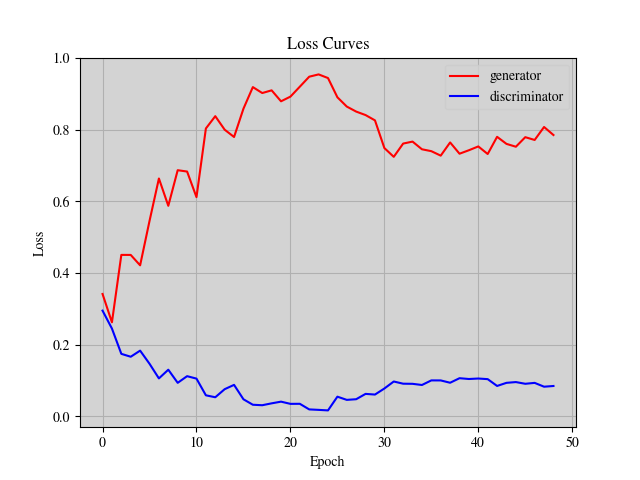

<Figure size 640x480 with 0 Axes>

In [18]:
seed_everything(SEED, workers=True)

generator = GraphGenerator(LATENT_DIM, BOND_DIM, NUM_ATOMS, ATOM_DIM)
discriminator = GraphDiscriminator(LATENT_DIM, BOND_DIM, ATOM_DIM)
model = GraphGAN(generator, discriminator, BATCH_SIZE, LR, MAX_EPOCH)
MODEL_NAME = model.__class__.__name__

tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
checkpoint = ModelCheckpoint(
    monitor='val_drug_candidate',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)

trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[checkpoint],
    log_every_n_steps=5,
)
trainer.fit(model)

## **Testing**

In [19]:
trainer.test(ckpt_path="best")

INFO: Restoring states from the checkpoint path at /content/epoch=2-step=8034.ckpt
INFO: Restoring states from the checkpoint path at /content/epoch=2-step=8034.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=2-step=8034.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/epoch=2-step=8034.ckpt
INFO: Loaded model weights from the checkpoint at /content/epoch=2-step=8034.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=2-step=8034.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_diversity       │     0.699667624644174     │
│    test_drug_candidate    │    0.49418753361792994    │
│     test_druglikeness     │    0.3501450490220322     │
│   test_natural_product    │    0.8156337026166338     │
│        test_novel         │    0.9994505494505495     │
│      test_solubility      │    0.2745691522736843     │
│   test_synthetizability   │    0.2772585608763738     │
│        test_unique        │   0.002197802299633622    │
│        test_valid         │     0.832190215587616     │
└───────────────────────────┴───────────────────────────┘

[{'test_valid': 0.832190215587616,
  'test_unique': 0.002197802299633622,
  'test_novel': 0.9994505494505495,
  'test_druglikeness': 0.3501450490220322,
  'test_solubility': 0.2745691522736843,
  'test_drug_candidate': 0.49418753361792994,
  'test_natural_product': 0.8156337026166338,
  'test_synthetizability': 0.2772585608763738,
  'test_diversity': 0.699667624644174}]

In [ ]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)

## **Inference**

In [ ]:
molecules = list()
legends = list()
smiles = list()
MAX_GRID = 9
index = 0

while index < MAX_GRID:
    InferenceDataset = QM9Dataset(split="inference")

    trainer = Trainer()
    adj, feat = trainer.predict(
        model=model,
        dataloaders=data.DataLoader(
            dataset=InferenceDataset,
            batch_size=1,
            shuffle=False,
        ),
        ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"),
    )[0]

    adj = (
        F.relu(
            F.one_hot(torch.argmax(adj, dim=1), BOND_DIM).permute(0, 3, 1, 2)
            - torch.eye(NUM_ATOMS).view(1, 1, NUM_ATOMS, NUM_ATOMS)
        )
        .data.cpu()
        .numpy()[0]
    )
    feat = F.one_hot(torch.argmax(feat, dim=2), ATOM_DIM).data.cpu().numpy()[0]

    mol = graph_to_molecule(adj, feat)
    if mol is None:
        continue
    if str(Chem.MolToSmiles(mol)) in SMILES:
        continue
    if str(Chem.MolToSmiles(mol)) not in smiles:
        smiles.append(str(Chem.MolToSmiles(mol)))
    else:
        continue
    molecules.append(mol)
    druglikeness = (
        MolecularMetrics.quantitative_estimation_druglikeness_scores([mol])
    ).mean()
    legends.append(
        smiles[-1] +
        "\n" +
        f"QED={round(druglikeness, 2)}"
    )
    index += 1


MolsToGridImage(
    [m for m in molecules if m is not None],
    molsPerRow=int(math.sqrt(MAX_GRID)),
    subImgSize=(250, 250),
    legends=legends,
)

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/GraphGAN_best.ckpt
INFO: Loaded model weights from the checkpoint at /content/

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/GraphGA

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/GraphGAN_best.ckpt
INFO: Loaded model weights from the checkpoint at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/GraphGAN_best.ckpt


Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/GraphGAN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
IN

Predicting: 0it [00:00, ?it/s]